In [11]:
import os
import pandas as pd
import plotly.express as px
from tqdm.notebook import tqdm
from multiprocess import Pool, cpu_count

pd.options.mode.copy_on_write = True


In [14]:
scores = pd.read_csv("sa_results.csv", index_col=0)
scores["Date"] = scores["Date"].astype("datetime64[ns]")
scores.dtypes


Top_Level_Folder            object
Mail_Folder                 object
Message_File                 int64
From                        object
To                          object
Cc                          object
Bcc                         object
Date                datetime64[ns]
joy                        float64
anger                      float64
fear                       float64
sadness                    float64
love                       float64
surprise                   float64
neg                        float64
neu                        float64
pos                        float64
compound                   float64
dtype: object

In [3]:
scores


,Top_Level_Folder,Mail_Folder,Message_File,From,To,Cc,Bcc,Date,joy,anger,fear,sadness,love,surprise,neg,neu,pos,compound
0,taylor-m,all_documents,1,['mark.taylor@enron.com'],['marc.r.cutler@bankamerica.com'],[],[],1998-10-30 14:43:00,0.870809,0.066835,0.040838,0.016119,0.003810,0.001589,0.000,0.936,0.064,0.2144
1,taylor-m,sent,1,['mark.taylor@enron.com'],['marc.r.cutler@bankamerica.com'],[],[],1998-10-30 14:43:00,0.870809,0.066835,0.040838,0.016119,0.003810,0.001589,0.000,0.936,0.064,0.2144
2,taylor-m,sent,2,['mark.taylor@enron.com'],['marc.r.cutler@bankamerica.com'],[],[],1998-10-30 14:56:00,0.955962,0.021567,0.013542,0.004886,0.002495,0.001548,0.000,0.782,0.218,0.6908
3,taylor-m,all_documents,2,['mark.taylor@enron.com'],['marc.r.cutler@bankamerica.com'],[],[],1998-10-30 14:56:00,0.955962,0.021567,0.013542,0.004886,0.002495,0.001548,0.000,0.782,0.218,0.6908
4,taylor-m,all_documents,3,['mark.taylor@enron.com'],['shari.stack@enron.com'],[],[],1998-10-30 15:02:00,0.517597,0.115636,0.269055,0.010137,0.002557,0.085018,0.013,0.886,0.101,0.9954
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
516340,fischer-m,all_documents,428,['denise.williams@enron.com'],['ge_benefits@enron.com'],[],[],2002-07-12 11:13:00,0.995261,0.001834,0.000816,0.001099,0.000776,0.000213,0.019,0.822,0.160,0.8446
516341,fischer-m,discussion_threads,339,['denise.williams@enron.com'],['ge_benefits@enron.com'],[],[],2002-07-12 11:13:00,0.995261,0.001834,0.000816,0.001099,0.000776,0.000213,0.019,0.822,0.160,0.8446
516342,fischer-m,notes_inbox,2,['denise.williams@enron.com'],['ge_benefits@enron.com'],[],[],2002-07-12 11:13:00,0.995261,0.001834,0.000816,0.001099,0.000776,0.000213,0.019,0.822,0.160,0.8446
516343,fischer-m,all_documents,429,['kurt.anderson@enron.com'],['gverkleeren@zilkha.com'],"['rwinsor@zilkha.com', 'jquick@zilkha.com', 'm...","['rwinsor@zilkha.com', 'jquick@zilkha.com', 'm...",2002-07-12 11:36:00,0.921587,0.042635,0.005179,0.026327,0.003220,0.001053,0.011,0.902,0.087,0.8910


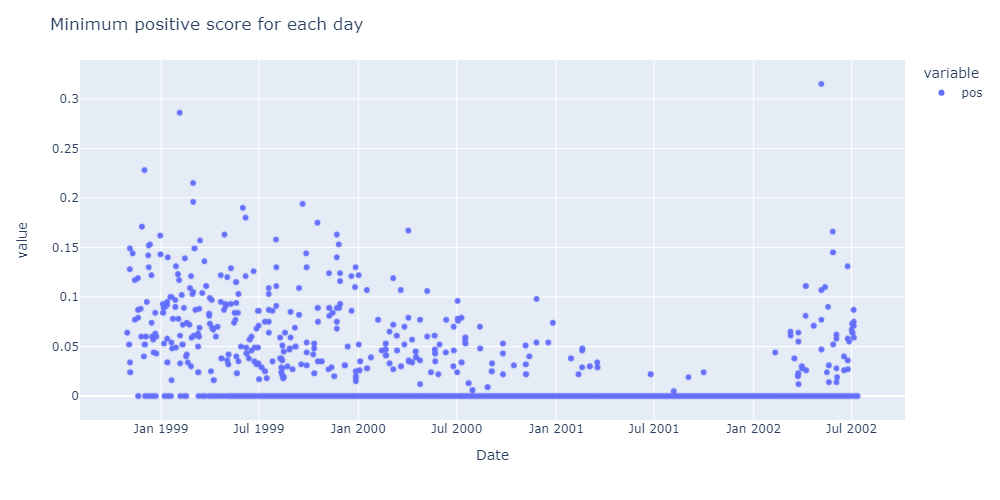

In [4]:
px.scatter(
    data_frame=scores[["Date", "pos"]]
    .rolling("1D", on="Date")
    .min(),
    x="Date",
    y=["pos"],
).update_layout(
    width=1000, height=500, title="Minimum positive score for each day"
).show(
    "png"
)


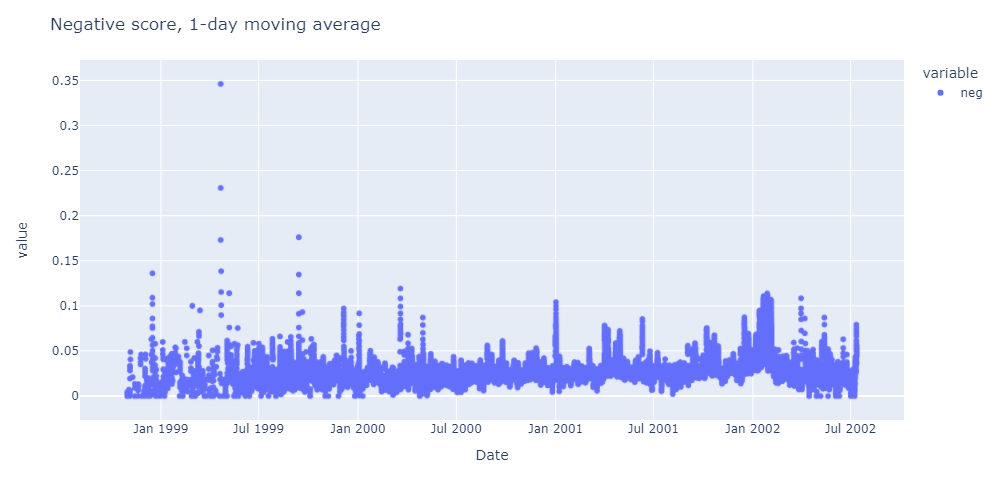

In [5]:
px.scatter(
    data_frame=scores[["Date", "neg"]]
    .rolling("1D", on="Date")
    .mean(),
    x="Date",
    y=["neg"],
).update_layout(
    width=1000, height=500, title="Negative score, 1-day moving average"
).show(
    "png"
)


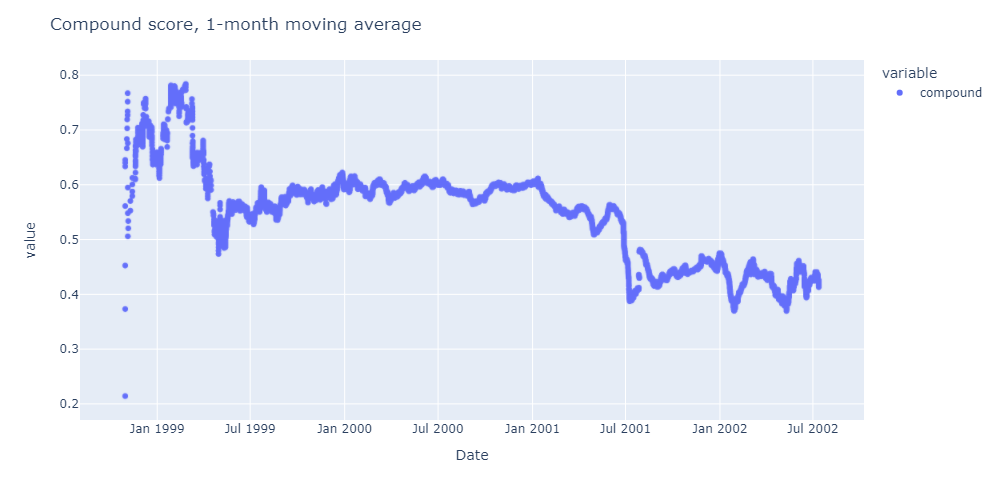

In [6]:
px.scatter(
    data_frame=scores[["Date", "compound"]]
    .rolling("30D", on="Date")
    .mean(),
    x="Date",
    y=["compound"],
).update_layout(
    width=1000, height=500, title="Compound score, 1-month moving average"
).show(
    "png"
)


In [7]:
if not os.path.exists("tlf_to_email.csv"):
    scores["Last_Name"] = scores["Top_Level_Folder"].str.split("-").str[0]
    sc_true_from = scores[
        scores.apply(
            lambda x: (x["Last_Name"] in x["From"]) and ("enron.com" in x["From"]), axis=1
        )
    ]

    tlf_groups = sc_true_from[["Top_Level_Folder", "From"]].groupby("Top_Level_Folder")

    tlf_to_email = tlf_groups.agg(pd.Series.mode)

    user_not_found =[
        x
        for x in scores["Top_Level_Folder"].unique().tolist()
        if x not in tlf_to_email.index.unique().tolist()
    ]

    for u in user_not_found:
        em = scores[scores["Top_Level_Folder"] == u]["From"].mode()
        tlf_to_email.loc[u] = em.values[0]
    tlf_to_email["From"] = [eval(x)[0] for x in tlf_to_email["From"].values.tolist()]
    tlf_to_email.to_csv("tlf_to_email.csv", index=True)

tlf_to_email = pd.read_csv("tlf_to_email.csv", index_col=0)
tlf_to_email


,From
Top_Level_Folder,
allen-p,phillip.allen@enron.com
arnold-j,john.arnold@enron.com
arora-h,harry.arora@enron.com
badeer-r,robert.badeer@enron.com
bailey-s,susan.bailey@enron.com
...,...
gilbertsmith-d,doug.gilbert-smith@enron.com
ybarbo-p,paul.y'barbo@enron.com
merriss-s,pete.davis@enron.com


In [26]:
if not os.path.exists("senders_timeline.csv"):
    from timeline_helpers import generate_timeline

    if __name__ == "__main__":
        cpus = cpu_count()
        arglist = tlf_to_email["From"].to_list()
        with Pool(processes=cpus) as mp_pool:
            mp_results = mp_pool.map_async(generate_timeline, arglist)
            mp_results.wait()

    mp_list = [df for df in mp_results.get()]
    del mp_results
    del mp_pool

    senders_timeline = pd.DataFrame(index=scores["Date"].to_list(), dtype="float64")
    senders_timeline.index.rename("Date", inplace=True)

    for temp_df in tqdm(mp_list):
        senders_timeline = senders_timeline.merge(
            temp_df, left_index=True, right_index=True, how="left"
        )
    senders_timeline = senders_timeline.dropna(how="all", inplace=False).groupby("Date").agg("mean")
    senders_timeline.index = senders_timeline.index.astype(dtype="datetime64[ns]")
    senders_timeline.to_csv("senders_timeline.csv", index=True)

senders_timeline = pd.read_csv("senders_timeline.csv", index_col=0)
senders_timeline


,phillip.allen@enron.com,john.arnold@enron.com,harry.arora@enron.com,robert.badeer@enron.com,susan.bailey@enron.com,eric.bass@enron.com,don.baughman@enron.com,sally.beck@enron.com,robert.benson@enron.com,lynn.blair@enron.com,...,jason.wolfe@enron.com,andy.zipper@enron.com,john.zufferli@enron.com,carol.clair@enron.com,robin.rodrigue@enron.com,doug.gilbert-smith@enron.com,paul.y'barbo@enron.com,pete.davis@enron.com,sean.crandall@enron.com,stephanie.panus@enron.com_y
Date,,,,,,,,,,,,,,,,,,,,,
1998-10-30 14:43:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1998-10-30 14:56:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1998-10-30 15:02:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1998-10-30 16:06:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1998-11-02 19:32:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2002-06-25 18:04:28,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2002-06-25 19:55:34,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2002-06-25 20:00:52,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [73]:
zzz.index.to_list()[0]


Timestamp('1998-10-30 00:00:00')

In [89]:
zzz = senders_timeline.copy(deep=True)
zzz.reset_index(inplace=True)
zzz["Date"] = zzz["Date"].dt.normalize()
zzz = zzz.groupby(by="Date").agg("mean")
zzz = zzz.reindex(pd.date_range(start=zzz.index.to_list()[0], end=zzz.index.to_list()[-1], freq="1D"))
zzz.reset_index(inplace=True, names="Date")
zzz


,Date,phillip.allen@enron.com,john.arnold@enron.com,harry.arora@enron.com,robert.badeer@enron.com,susan.bailey@enron.com,eric.bass@enron.com,don.baughman@enron.com,sally.beck@enron.com,robert.benson@enron.com,...,jason.wolfe@enron.com,andy.zipper@enron.com,john.zufferli@enron.com,carol.clair@enron.com,robin.rodrigue@enron.com,doug.gilbert-smith@enron.com,paul.y'barbo@enron.com,pete.davis@enron.com,sean.crandall@enron.com,stephanie.panus@enron.com_y
0,1998-10-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1998-10-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1998-11-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1998-11-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1998-11-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1330,2002-06-21,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0258
1331,2002-06-22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1332,2002-06-23,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1333,2002-06-24,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [93]:
zzz_no_date

,phillip.allen@enron.com,john.arnold@enron.com,harry.arora@enron.com,robert.badeer@enron.com,susan.bailey@enron.com,eric.bass@enron.com,don.baughman@enron.com,sally.beck@enron.com,robert.benson@enron.com,lynn.blair@enron.com,...,jason.wolfe@enron.com,andy.zipper@enron.com,john.zufferli@enron.com,carol.clair@enron.com,robin.rodrigue@enron.com,doug.gilbert-smith@enron.com,paul.y'barbo@enron.com,pete.davis@enron.com,sean.crandall@enron.com,stephanie.panus@enron.com_y
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1330,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0258
1331,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1332,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1333,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [130]:
zzz_no_date = zzz.copy(deep=True)
zzz_no_date.drop(columns=["Date"], inplace=True)
zzz_no_date = zzz_no_date.rolling(60, min_periods=1, win_type="blackmanharris").agg(
    "mean"
)
zzz_no_date["Date"] = zzz["Date"]
px.line(
    data_frame=zzz_no_date,
    x="Date",
    y=["phillip.allen@enron.com", "john.arnold@enron.com", "mark.taylor@enron.com"],
).update_layout(width=1200, height=600)


In [10]:
import networkx as nx
from matplotlib import pyplot as plt
from tqdm.notebook import tqdm


  0%|          | 0/516345 [00:00<?, ?it/s]

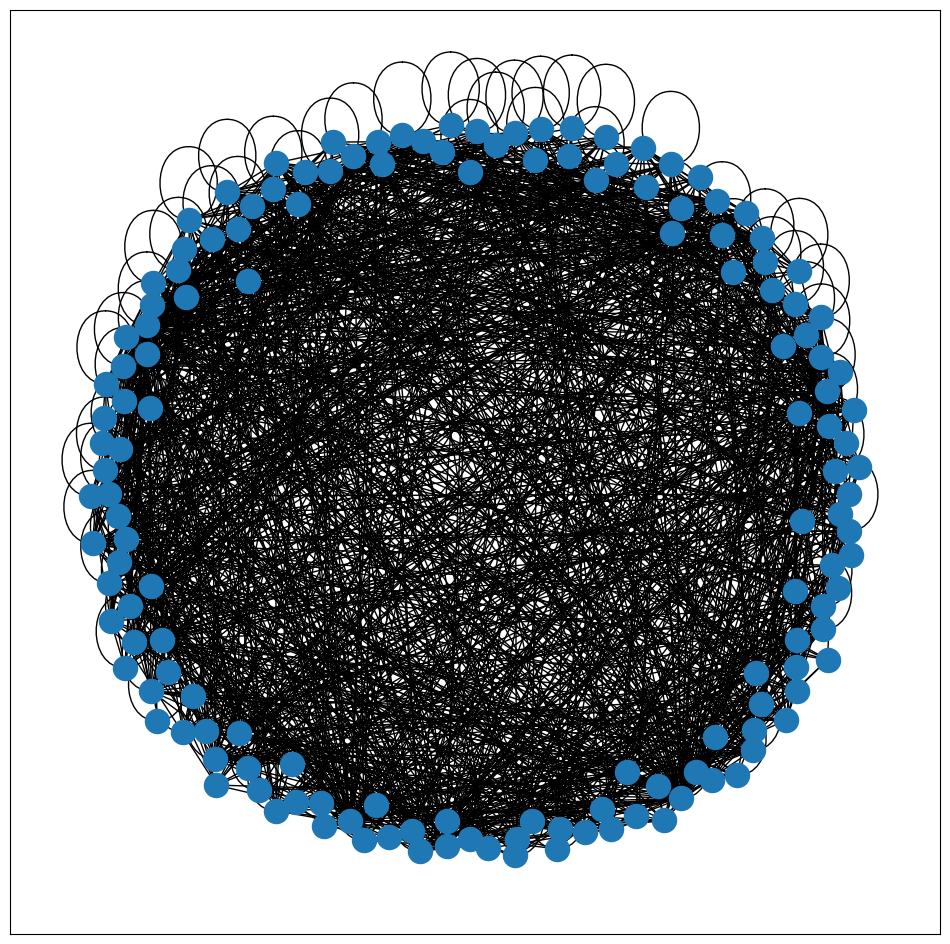

In [11]:
G = nx.Graph()
mail_list = tlf_to_email["From"].to_list()
G.add_nodes_from(mail_list)
base_layout = nx.layout.spring_layout(G)
for i in tqdm(range(scores.shape[0])):
    m = scores.iloc[i]
    email_from = eval(m["From"])[0]
    if email_from in mail_list:
        email_to = eval(m["To"])
        for a in email_to:
            if a in mail_list:
                G.add_edge(email_from, a)
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 12))
nx.draw_networkx(G, pos=base_layout, with_labels=False)
plt.show()
